In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
from time import time, strptime, mktime
torch.manual_seed(0)
np.random.seed(0)
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black"}
plt.rcParams.update(params)

In [3]:
LAG = 12
SIND = 30
STOPS = 5
SROUTE = 'M102_0'

data = history_byname(SROUTE)
print(data.shape)

(13248, 59)


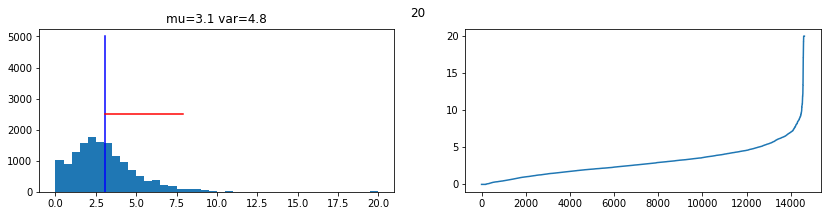

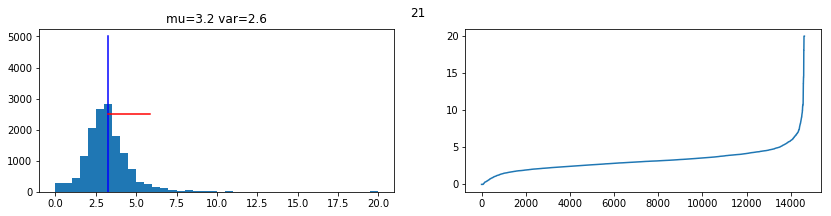

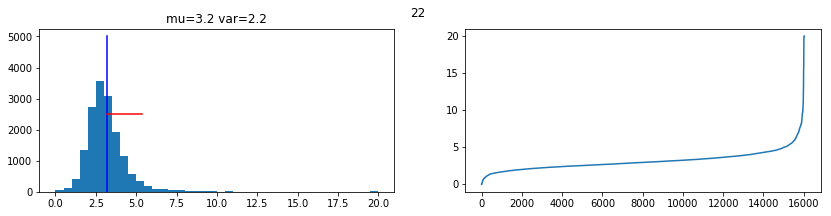

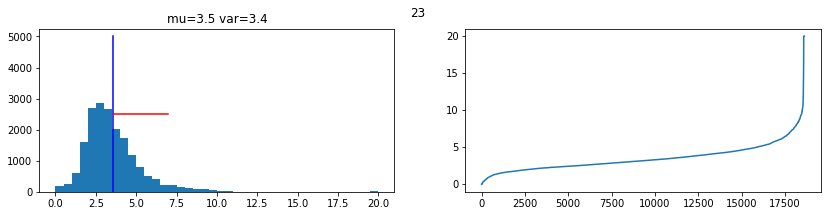

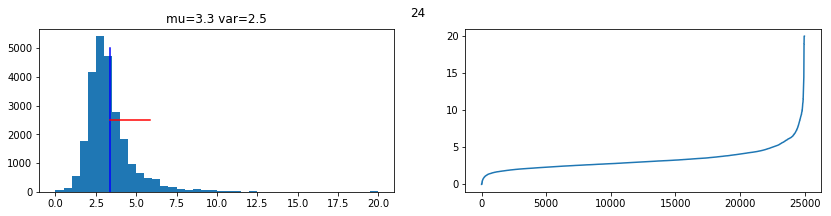

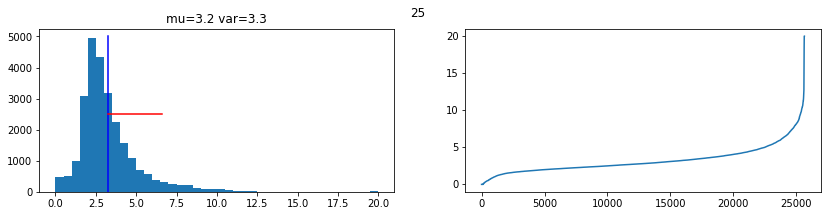

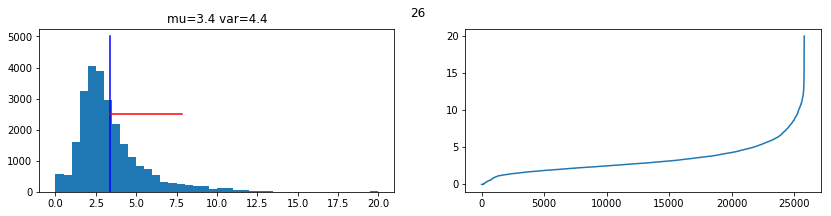

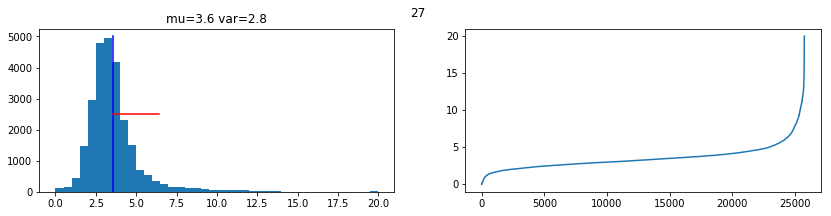

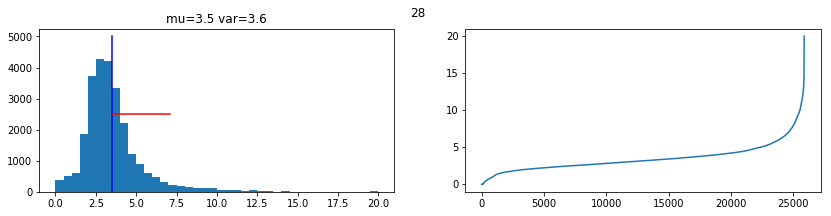

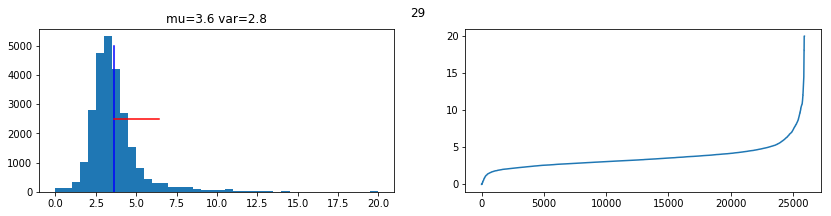

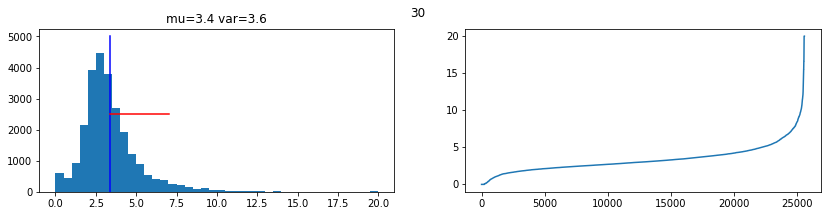

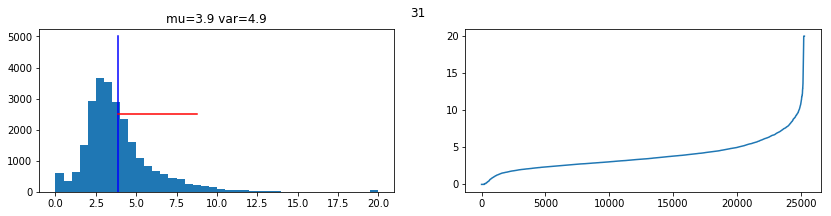

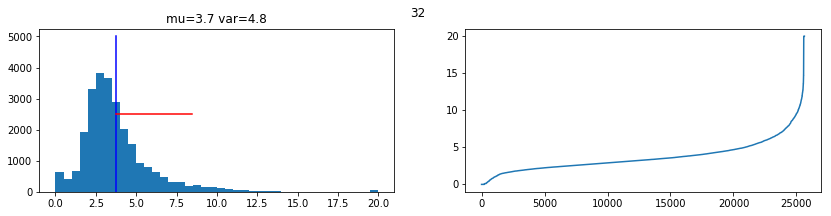

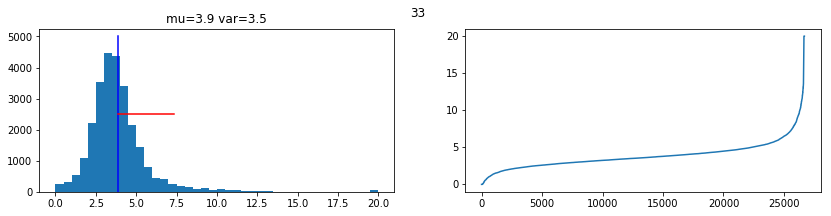

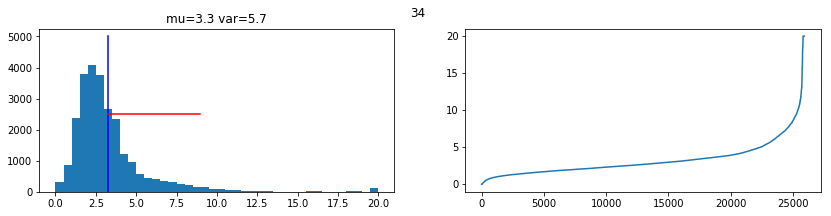

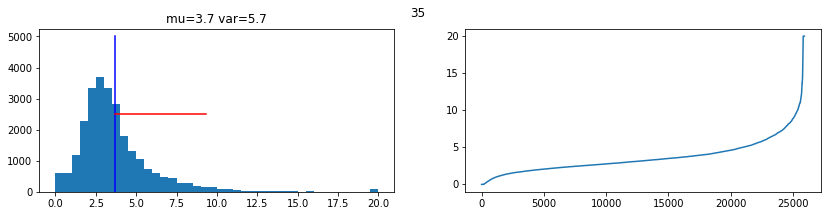

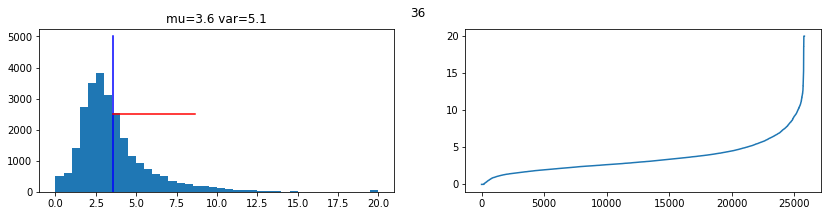

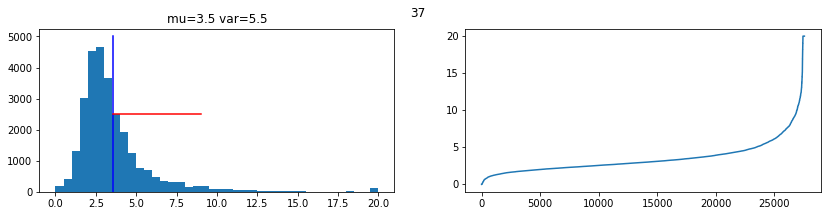

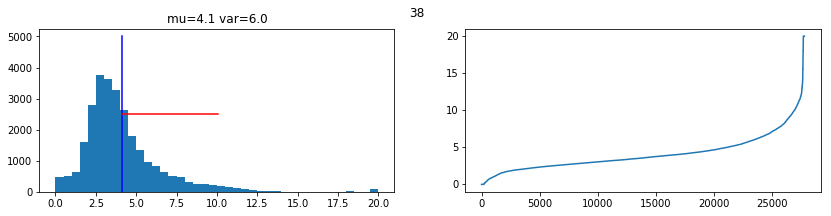

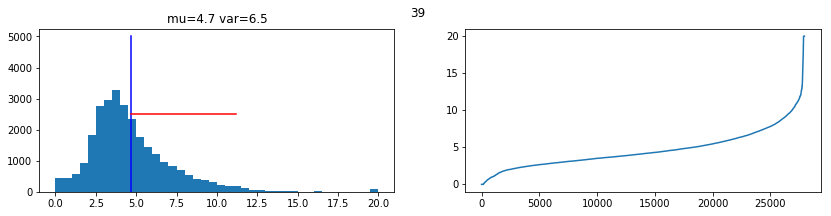

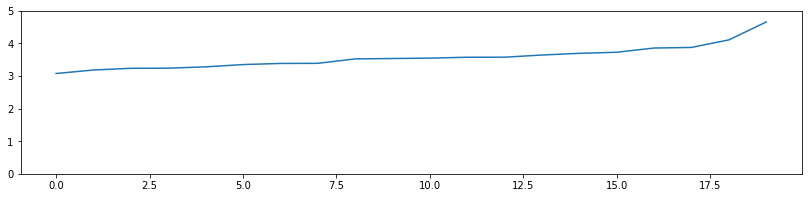

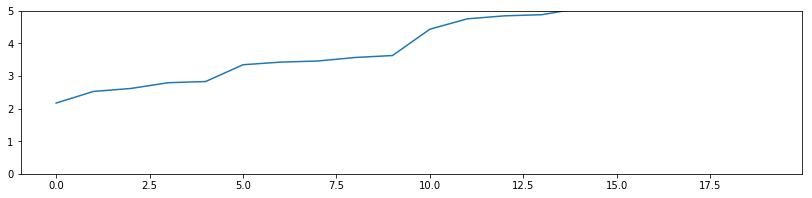

In [25]:
stats = []
for sind in range(20, 40):
    distdata = SingleStop(
        SROUTE, sind, 'train', 1, norm=10,
        lag=12, stops=1, verbose=False)
    speeds = []
#     print(distdata.norm)
    for hist in distdata:
        speeds += hist.reshape(12 * 1).tolist()

    speeds = np.array(speeds)
    speeds *= 10
    plt.figure(figsize=(14, 3))
    plt.suptitle(sind)
    mu = np.mean(speeds)
    var = np.var(speeds)
    stats.append((mu, var))
    plt.subplot(1, 2, 1)
    plt.gca().set_title('mu=%.1f var=%.1f' % (mu, var))
    plt.hist(sorted(speeds), bins=40)
    plt.plot([mu, mu], [0, 5000], color='blue')
    plt.plot([mu, mu + var], [2500, 2500], color='red')
    
    plt.subplot(1, 2, 2)
    plt.plot(sorted(speeds))
    
    plt.show(); plt.close()    
#     break
mus, vars = zip(*stats)
plt.figure(figsize=(14, 3))
plt.plot(sorted(mus))
plt.ylim(0, 5)
plt.show(); plt.close()

plt.figure(figsize=(14, 3))
plt.plot(sorted(vars))
plt.ylim(0, 5)
plt.show(); plt.close()
    


* Few speeds are blow 1
* Speeds are concentrated around < 5. There is no clear "jam" speed

In [109]:
distdata = SingleStop(
    SROUTE, SIND, 'train', 1, norm=10,
    lag=12, stops=1, verbose=True)

Locals dataset: train (metadata/2h/M102_0.json)
 [*] Loaded routes: 1 (0.34s)
 [*] Has trainable inds: 109128
 [*] Subset train: 3069
 [*] Subset in Stop-30: 2129


In [110]:
distdata.mat.shape

(13248, 59)

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


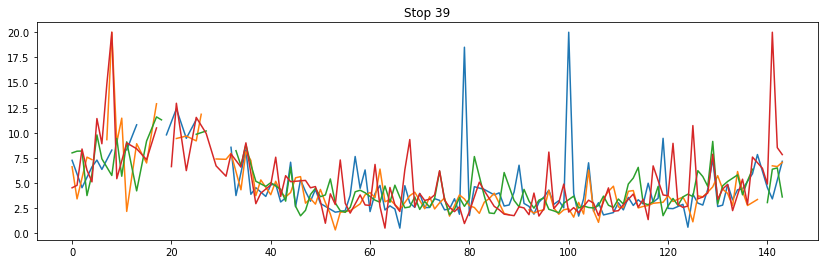

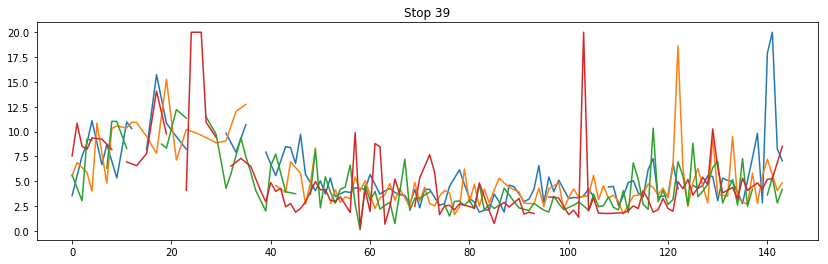

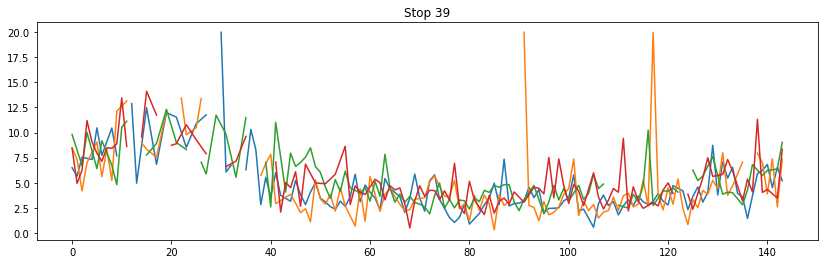

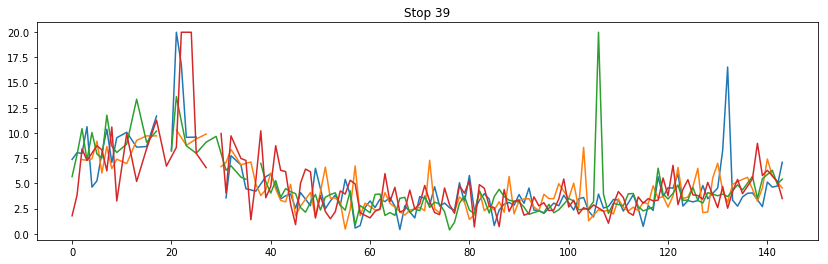

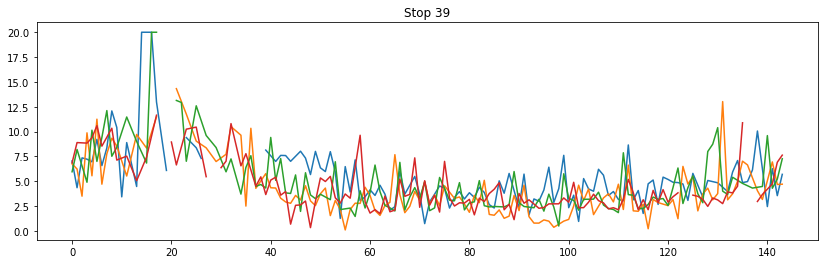

In [113]:
dmat = distdata.mat.copy()
dmat[dmat > 20] = 20
interv = 144
byday = []
for ti in range(0, dmat.shape[0], interv):
    byday.append(dmat[ti:ti+interv, SIND].copy())

for bi in range(5):
    plt.figure(figsize=(14, 4))
    for ii in range(1, 5):
        plt.title('Stop %d' % (sind))
        plt.plot(byday[-ii-5*bi])
    plt.show(); plt.close()

### Investigating time-lag

In [26]:
VIEW_LAG=96
viewset = SingleStop(
    SROUTE, SIND, 'test', 32, 
    lag=VIEW_LAG, stops=5)
viewset = [viewset[ii] for ii in range(1)]

Locals dataset: test (metadata/16h/M102_0.json)
 [*] Loaded routes: 1 (0.00s)
 [*] Has trainable inds: 262
 [*] Subset test: 15
 [*] Subset in Stop-30: 1


In [33]:
ts = viewset[0]

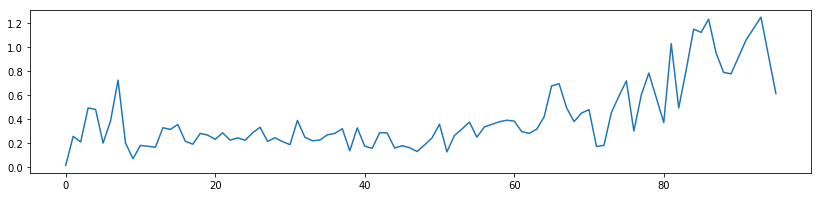

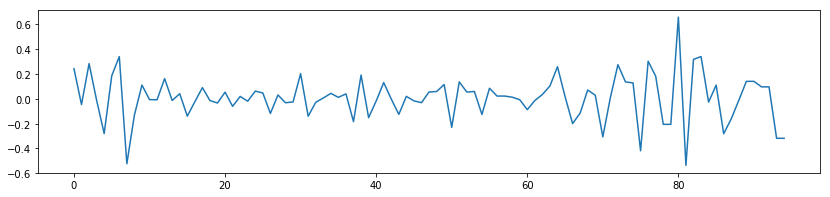

In [36]:
def lagdiff(many, lag=1):
    diff = np.zeros((many.shape[0]-1, many.shape[1]))
    for ti in range(many.shape[1]):
        series = many[:, ti]
        for ii in range(many.shape[0]-1):
            diff[ii, ti] = series[ii+1] - series[ii]
    return diff

plt.figure(figsize=(14, 3))
plt.plot(ts[:, 0])
plt.show(); plt.close()

plt.figure(figsize=(14, 3))
plt.plot(lagdiff(ts)[:, 0])
plt.show(); plt.close()

In [147]:
rawhist = []
with open('/home/ubuntu/datasets-aux/MTA-Bus-Time_.2014-10-31.txt') as fl:
    line = fl.readline()
    while line:
        if 'M102' in line and 'NULL' not in line:
            rawhist.append(line)
        line = fl.readline()

In [148]:
print(len(rawhist))
print(fmt(rawhist[0]))
hist = list(map(fmt, rawhist))
hist = list(filter(lambda obj: obj['direction'] == 0, hist))
hist = list(filter(lambda obj: obj['phase'], hist))

24536
{'dist': 9197.63947615755, 'phase': True, 'stop': 'MTA_403425', 'direction': 1, 'time': time.struct_time(tm_year=2014, tm_mon=10, tm_mday=31, tm_hour=4, tm_min=0, tm_sec=5, tm_wday=4, tm_yday=304, tm_isdst=-1), 'routeid': 'MTA NYCT_M102', 'busid': '5880'}


In [154]:
print(len(group(hist, 'busid')))
print(len(group(hist, 'routeid')))
print(len(group(hist, 'phase')))

45
1
1


In [216]:
buses = group(hist, 'busid')
bus_ids = list(buses.keys())

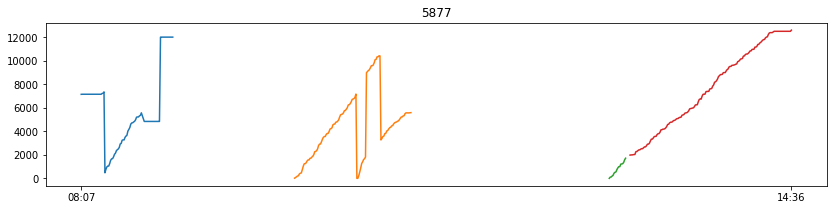

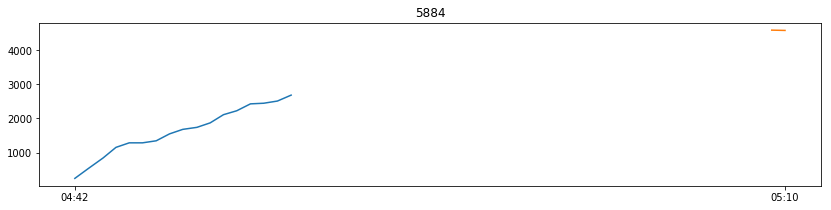

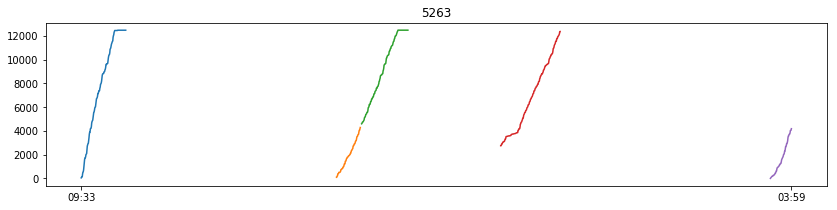

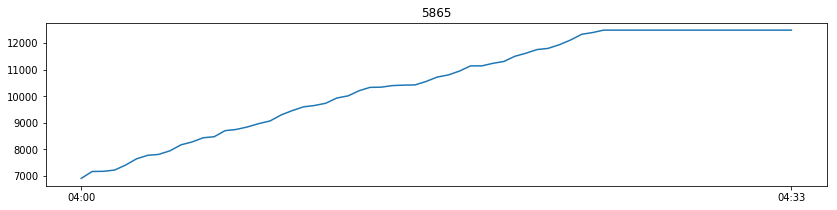

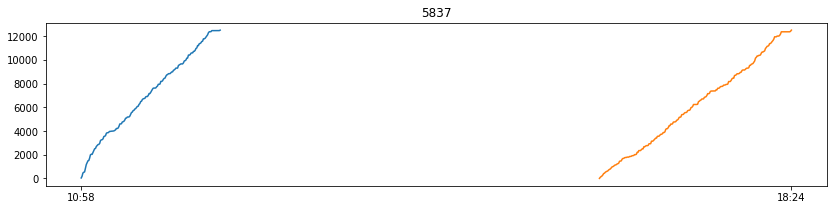

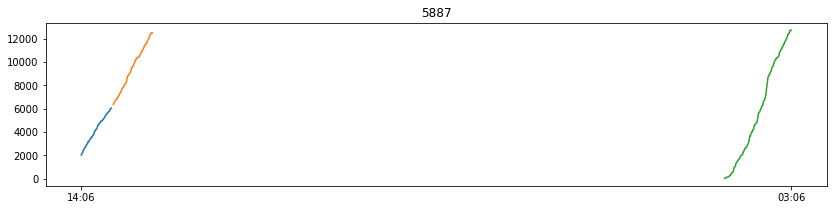

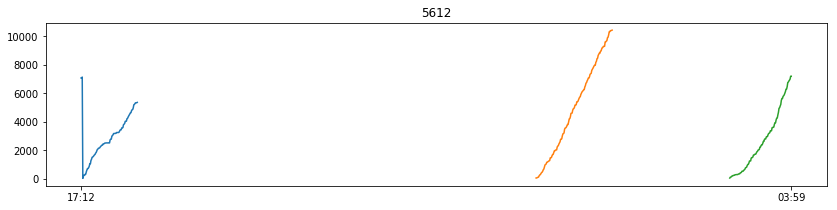

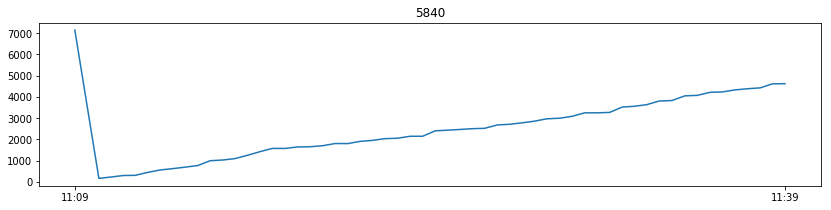

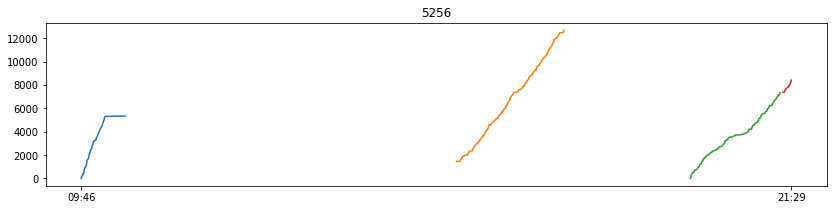

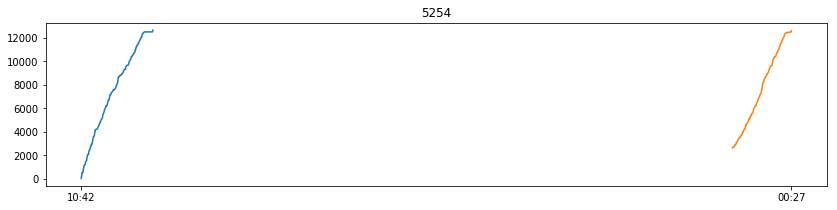

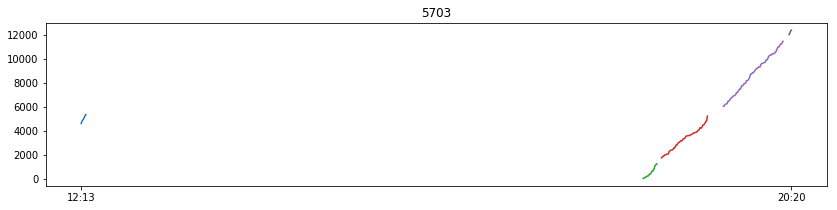

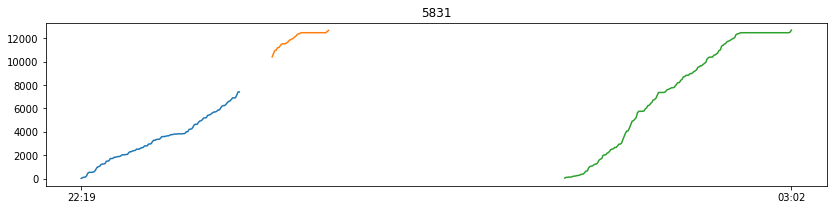

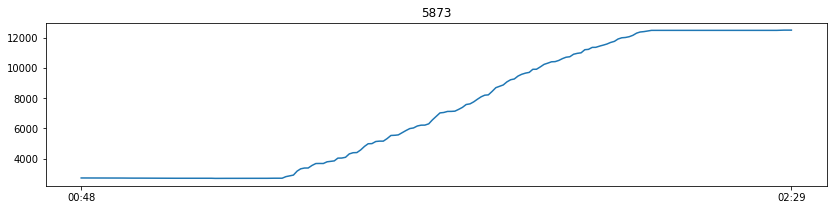

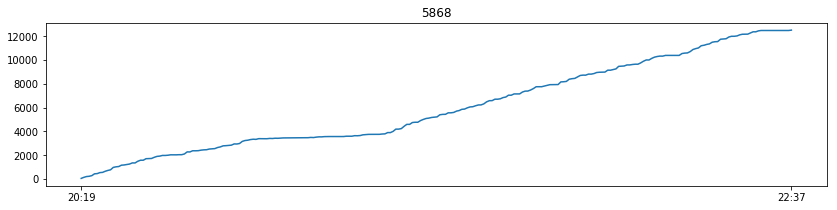

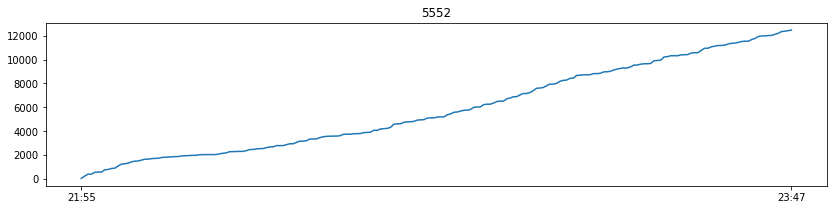

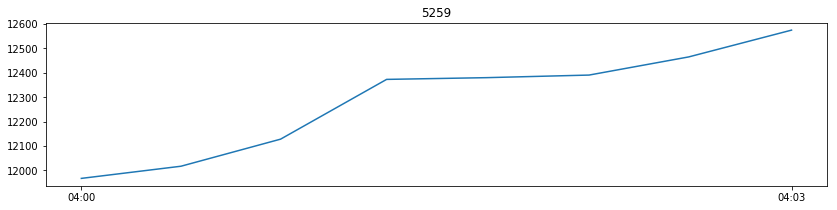

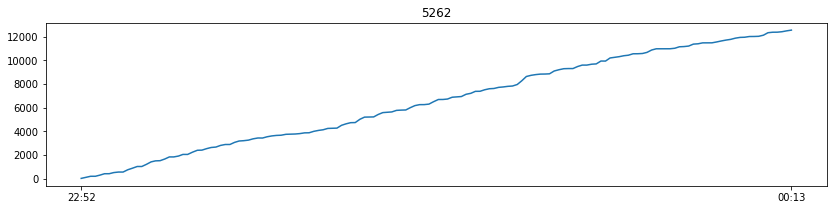

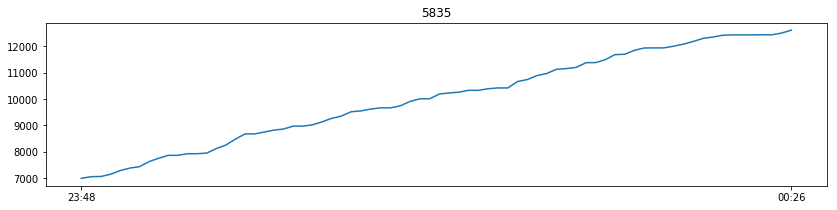

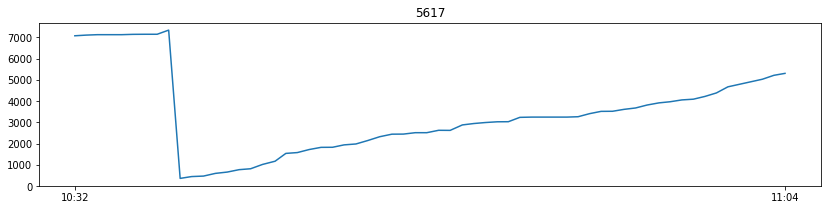

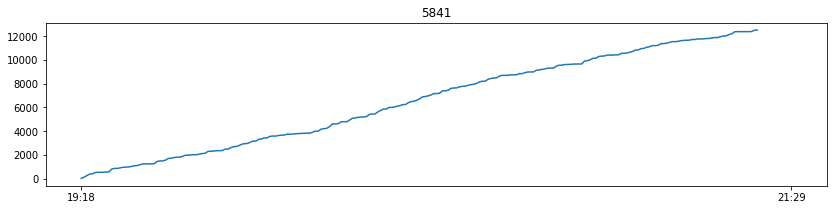

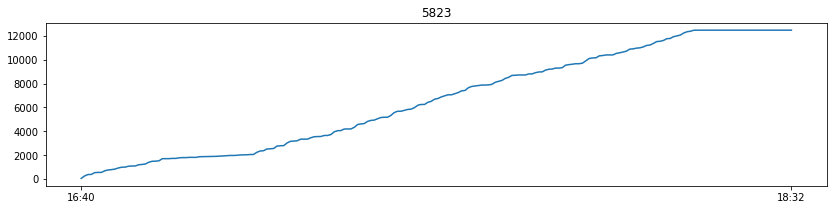

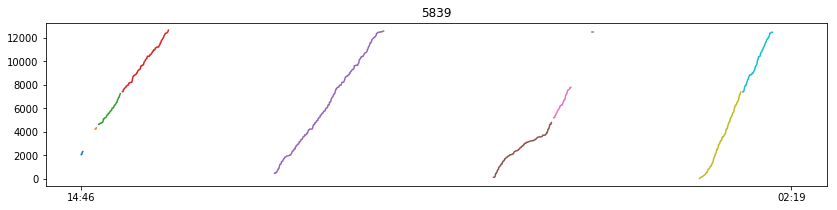

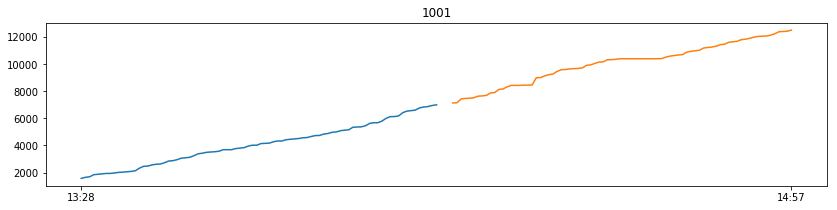

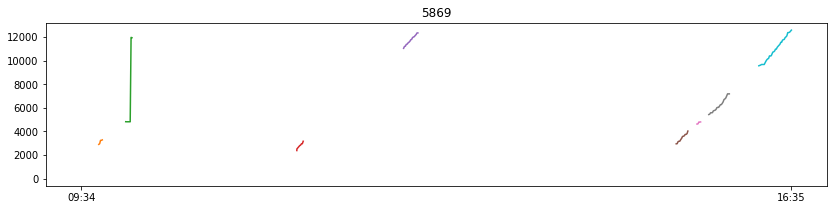

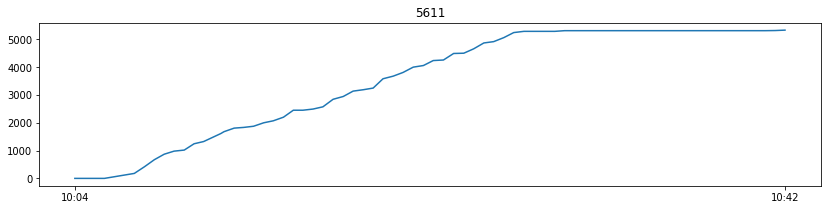

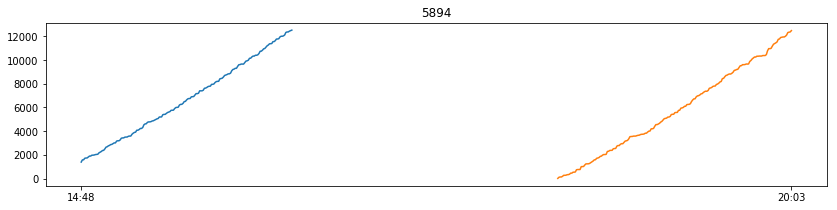

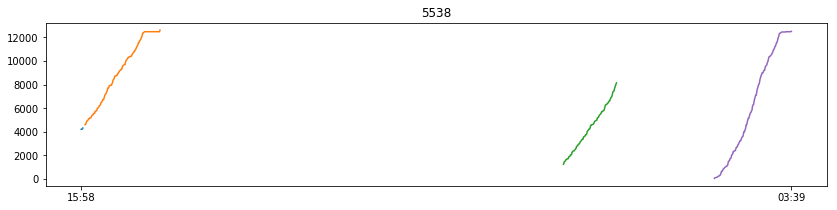

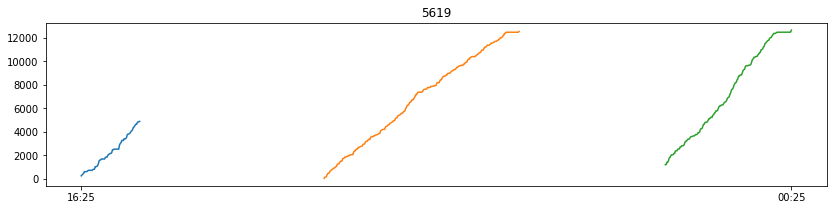

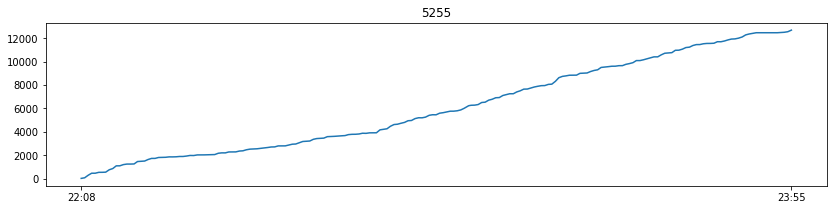

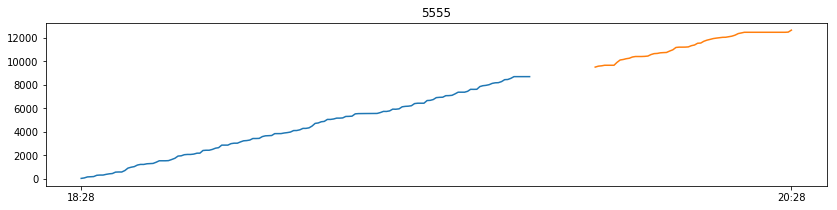

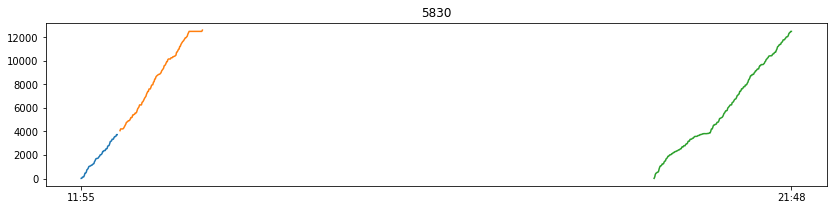

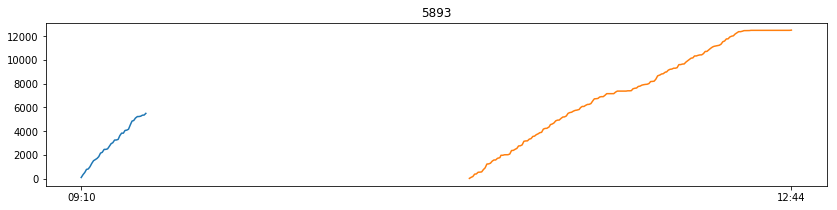

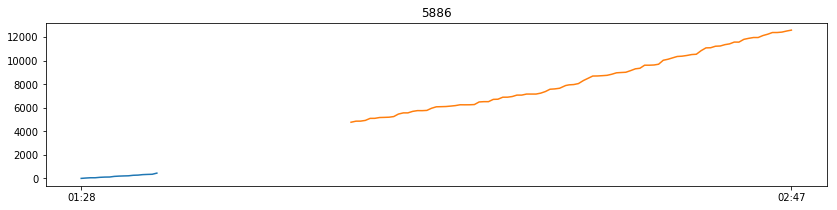

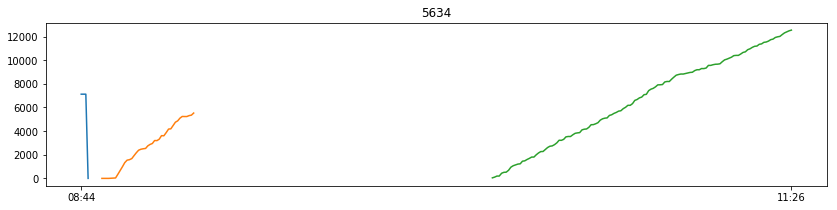

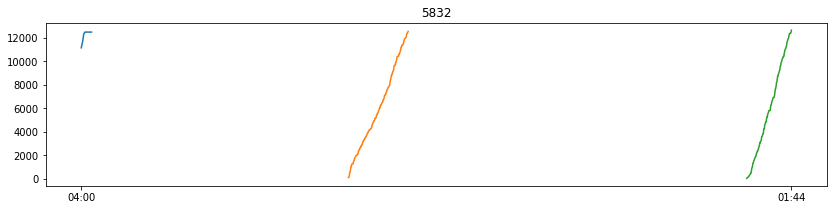

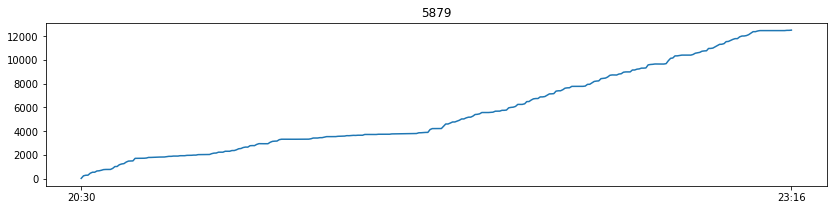

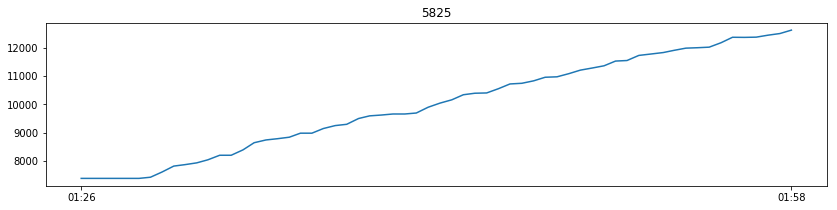

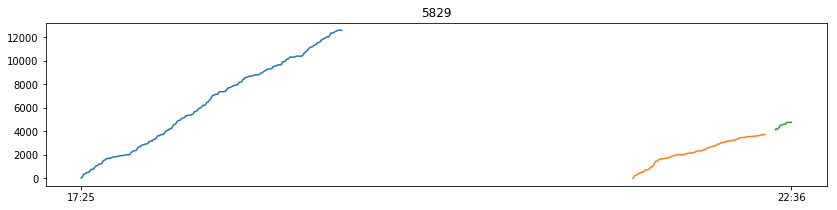

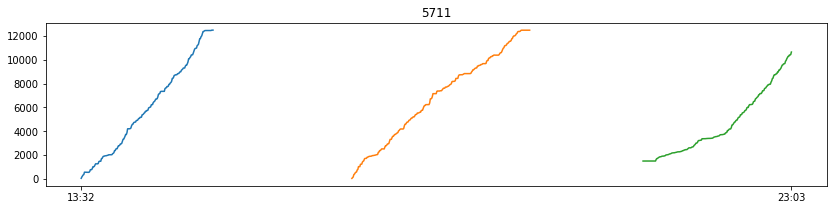

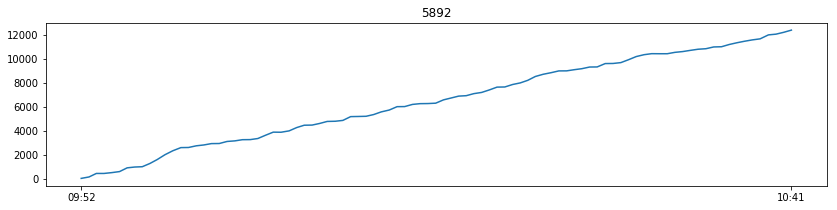

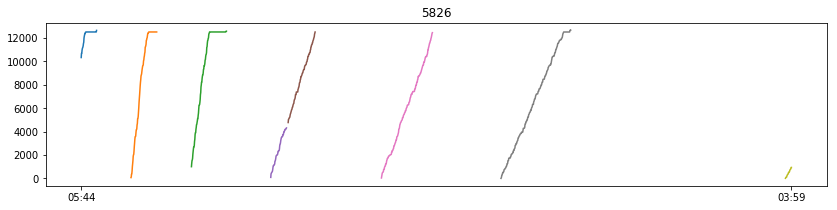

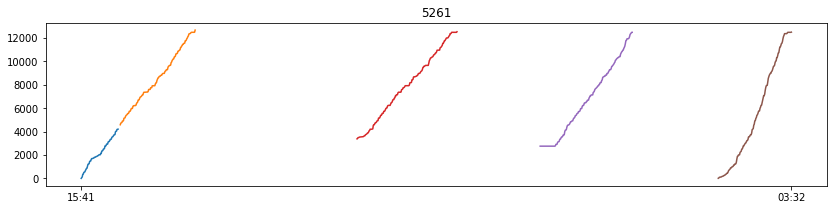

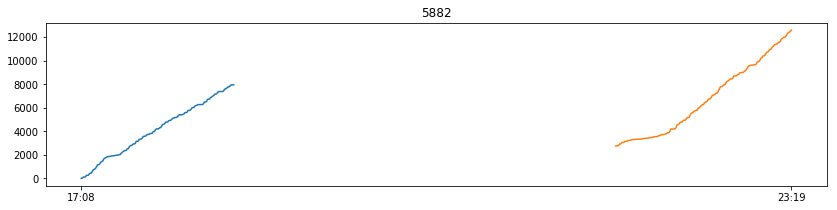

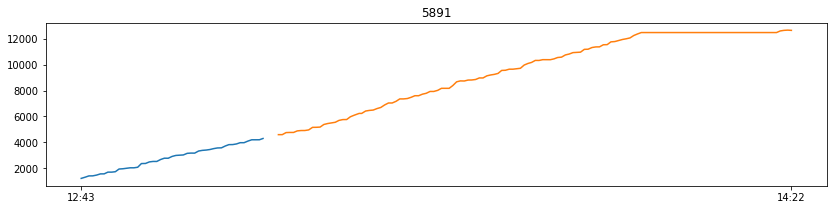

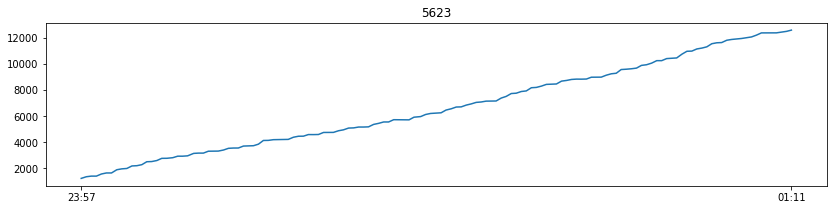

In [223]:
from time import strftime

def time_plot(travel):
    plt.figure(figsize=(14, 3))
    plt.title(bid)
    segs = find_segs(travel)
    for seg in segs:
        plt.plot([mktime(obj['time']) for obj in seg], [obj['dist'] for obj in seg])
#     plt.plot([mktime(obj['time']) for obj in travel], [obj['dist'] for obj in travel])
    plt.xticks([mktime(travel[0]['time']), mktime(travel[-1]['time'])], [
        strftime('%H:%M', travel[0]['time']),
        strftime('%H:%M', travel[-1]['time'])
    ])
    plt.show(); plt.close()
    
for bid in bus_ids:
    travel = buses[bid]
    
    for ii in range(len(travel)-1):
        assert travel[ii+1]['time'] > travel[ii]['time']
    
    time_plot(travel)
#     break

### given segment, find all entries that travelled there

In [78]:
from glob import glob
from utils import *
st, ed = '401844', '450066'
# st, ed = '401844','450417'
# st, ed = '403259', '401851'
# st, ed = '402694', '403434'
# st, ed = '404299', '404300'
# st, ed = '401840', '401842'
# st, ed = "402130", '402133'

# st, ed = '402143', '402145'
segstr = '\n'.join([st, ed])
matches = []
sfiles = glob('data/stopcodes_sequence/*.txt')
for sname in sfiles:
    with open(sname) as fl:
        raw = fl.read()
    if segstr in raw:
        matches.append(fileName(sname).split('_')[0])
print(matches)

['QM12', 'QM24', 'QM10', 'QM12', 'QM10', 'QM24']


In [79]:
raw_seghist = []
with open('/home/ubuntu/datasets-aux/mta/MTA-Bus-Time_.2014-08-27.txt') as fl:
# with open('/home/ubuntu/datasets-aux/MTA-Bus-Time_.2014-10-28.txt') as fl:
# with open('/home/ubuntu/datasets-aux/MTA-Bus-Time_.2014-10-30.txt') as fl:
# with open('/home/ubuntu/datasets-aux/MTA-Bus-Time_.2014-10-31.txt') as fl:
    _ = fl.readline()
    line = fl.readline()
    while line:
        if 'NULL' not in line:
#         if 'NULL' not in line and 'IN_PROGRESS' in line:
            if any([bid in line for bid in matches]):
#                 if any([sid in line for sid in [st, ed]]):
                try:
                    raw_seghist.append(fmt(line))
                except:
                    print(line)
                    assert False
        line = fl.readline()

In [80]:
print(len(raw_seghist))
seghist = list(filter(lambda obj: obj['direction'] == 1, raw_seghist))
seghist = list(filter(lambda obj: obj['phase'], seghist))
print(len(seghist))
# 98348
# 48978
# 302054
# 151724

11974
5831


In [81]:
from utils import *
print(len(group(seghist, 'busid')))
print(len(group(seghist, 'routeid')))
print(len(group(seghist, 'phase')))

44
3
1


1. Skips in distances are averaged between rel. next and rel. prev
2. static values are stripped from each end

In [83]:
from utils import *
from datetime import datetime
bybus = group(seghist, 'busid')

bus_used = {}
skipped = 0
useable = []
useable_post = []
PLOT=False
stops = {}
# for ii, (bid, travel) in enumerate(list(bybus.items())[:50]):
for ii, (bid, travel) in enumerate(bybus.items()):
    for ent in travel:
        stops[ent['stop']] = True
    inseg = [(mktime(ent['time']), ent['dist']) for ent in travel if ed in ent['stop']]
    if len(inseg) == 0:
        skipped += 1
        continue

    if PLOT: 
        print()
        print(travel[0]['routeid'], len(inseg))
        plt.figure(figsize=(14, 3))
    
    segs = find_segs(travel)
    if PLOT: 
        for seg in segs:
            plt.plot(
                [mktime(ent['time']) for ent in seg], 
                [ent['dist'] for ent in seg], color='C0')
        its, ids = zip(*inseg)
        plt.scatter(its, ids, color='C1')
        plt.show(); plt.close()
    if PLOT: plt.figure(figsize=(14, 3))
        
    tlast = None    
    for si, seg in enumerate(segs):
        if len(seg) <= 1:
            continue
        if len(seg) < 40: continue
        vs = est_velocity(seg)
#         vs = strip_seg(vs, prop='vel')
#         if len(vs) < 30: continue
        useable.append(lscopy(vs))
        bus_used[bid] = True
        
        velocity = np.array([obj['vel'] for obj in vs])
        ts = np.array([mktime(ent['time']) for ent in vs])
        if tlast is not None: ts -= (ts[0] - tlast)
        tlast = ts[-1]
        if PLOT: plt.plot(ts, velocity, color='#FF990055')
        
        
        _ = np.array([obj['vel'] for obj in remove_stops(vs)])
        vs, rmd = remove_peaks(vs, maxv=60)
        if rmd > 3: # fix max 3 peaks.. otherwise unreliable bus
            continue

        msize=5
        mhalf = int(msize//2)
        mean_vs = smooth_mean(lscopy(vs), fsize=msize)
        
        ssize=5
        shalf = int(ssize//2)
        skewed_vs = smooth_skewed(lscopy(vs), fsize=ssize, expval=1.1)
        
        rsize=5
        rhalf = int(rsize//2)
        range_vs = smooth_range(lscopy(vs), fsize=rsize)

#         velocity = np.array([obj['vel'] for obj in vs])
        useable_post.append([mean_vs, skewed_vs, range_vs])
        if PLOT: 
            plt.plot(ts[mhalf:-mhalf], vonly(mean_vs), color='C0')
            plt.plot(ts[shalf:-shalf], vonly(skewed_vs), color='C3')
            plt.plot(ts[:-5], vonly(range_vs), color='C4')
            plt.plot([ts[-1], ts[-1]], [0, 40], color='black')
            
            inseg = list(zip(ts[mhalf:-mhalf], skewed_vs))
            inseg = [ent for ent in inseg if ed in ent[1]['stop']]
            if len(inseg):
                ts, ents = zip(*inseg)
                if any([val > 20 for val in vonly(ents)]):
                    print('anomaly')
                plt.scatter(ts, vonly(ents), color='C1')
                plt.xticks(
                    [ts[-1]],
                    [hdiff(ents[0]['time'], ents[-1]['time'])])
    if PLOT: 
        plt.ylim(-5, 60)
        plt.show(); plt.close()
#     break
    sys.stdout.write('%d/%d    \r' % (ii, len(bybus)))
sys.stdout.flush()
print()
print(len(bus_used), len(bybus), skipped)
# list(stops.keys())

43/44    
29 44 15


In [84]:
print(len(useable))
inseg = []
for seg in useable:
    for ent in seg:
        if ed in ent['stop']:
            inseg.append(ent)
print(len(inseg))

47
150


Kdd data not found.


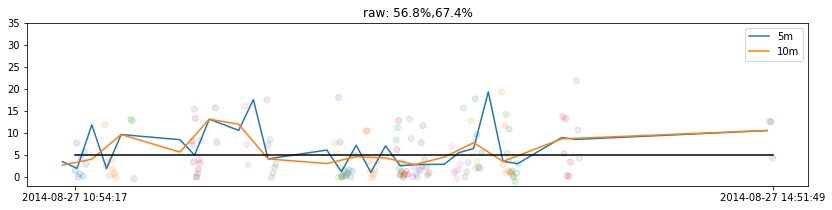

Kdd data not found.


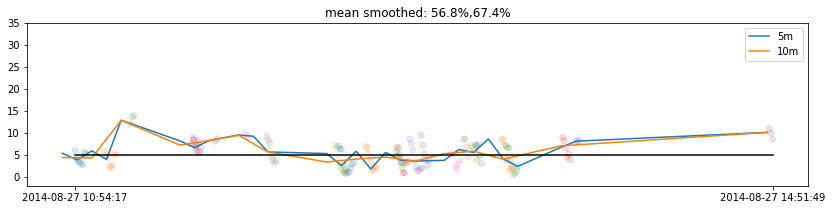

Kdd data not found.


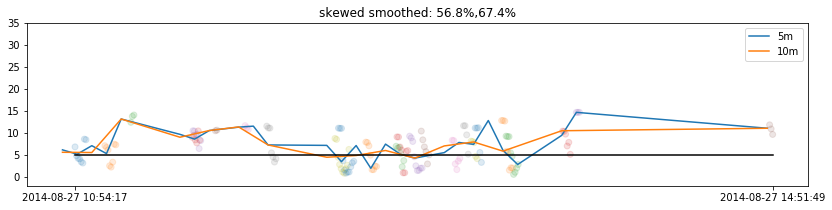

Kdd data not found.


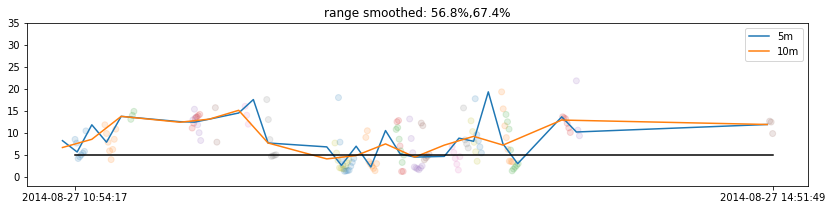

In [86]:
tints = [5, 10]
seg_scatter(useable, st, ed, title='raw', tints=tints)
mvs, svs, rvs = zip(*useable_post)
seg_scatter(mvs, st, ed, title='mean smoothed', tints=tints)
seg_scatter(svs,st, ed, title='skewed smoothed', tints=tints)
seg_scatter(rvs,st, ed, title='range smoothed', tints=tints)